In [1]:
#Könyvtár behívása
import pandas as pd

In [2]:
#Adathalmaz beolvasása
root = r"bank+marketing\bank\bank-full.csv"
ah = pd.read_csv(root, sep=';')

In [3]:
print(f"Sorok: {len(ah)}")
print(f"Változók (oszlopok száma): {len(ah.columns)}")
print(ah.head())
print(ah.describe())
print(ah['job'].value_counts())
print(ah['balance'].describe())

Sorok: 45211
Változók (oszlopok száma): 17
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
                age        balance           day      duration      

In [20]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = ah[['age', 'balance']].copy()
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
ah['Klaszterközéppont'] = kmeans.fit_predict(X_scaled)

cluster_summary = ah.groupby('Klaszterközéppont').agg({
    'age': 'mean',
    'balance': 'mean',
    'cluster': 'count'
}).rename(columns={'age': 'átlag kor',
                   'balance': 'átlag egyenleg',
                   'cluster': 'ügyfelek száma'})

print(cluster_summary)

                   átlag kor  átlag egyenleg  ügyfelek száma
Klaszterközéppont                                           
0                  31.178757      859.105614           18293
1                  56.220818     1325.483730           10049
2                  43.057663    14019.775417            1318
3                  42.357469      905.164491           15551


In [27]:
# cluster_summary DataFrame-ből lista készítése
cluster_params = []
for idx, row in cluster_summary.iterrows():
    cluster_params.append({
        'mean_age': round(row['átlag kor'], 2),
        'mean_balance': round(row['átlag egyenleg'], 2),
        'n_samples': int(row['ügyfelek száma'])
    })

print(cluster_params)

[{'mean_age': np.float64(31.18), 'mean_balance': np.float64(859.11), 'n_samples': 18293}, {'mean_age': np.float64(56.22), 'mean_balance': np.float64(1325.48), 'n_samples': 10049}, {'mean_age': np.float64(43.06), 'mean_balance': np.float64(14019.78), 'n_samples': 1318}, {'mean_age': np.float64(42.36), 'mean_balance': np.float64(905.16), 'n_samples': 15551}]


<>:77: SyntaxWarning: invalid escape sequence '\k'
<>:77: SyntaxWarning: invalid escape sequence '\k'
C:\Users\Balázs\AppData\Local\Temp\ipykernel_120836\1193556583.py:77: SyntaxWarning: invalid escape sequence '\k'
  plt.savefig('ábrák\kmeans_cluster_viz.png', dpi=300, bbox_inches='tight')


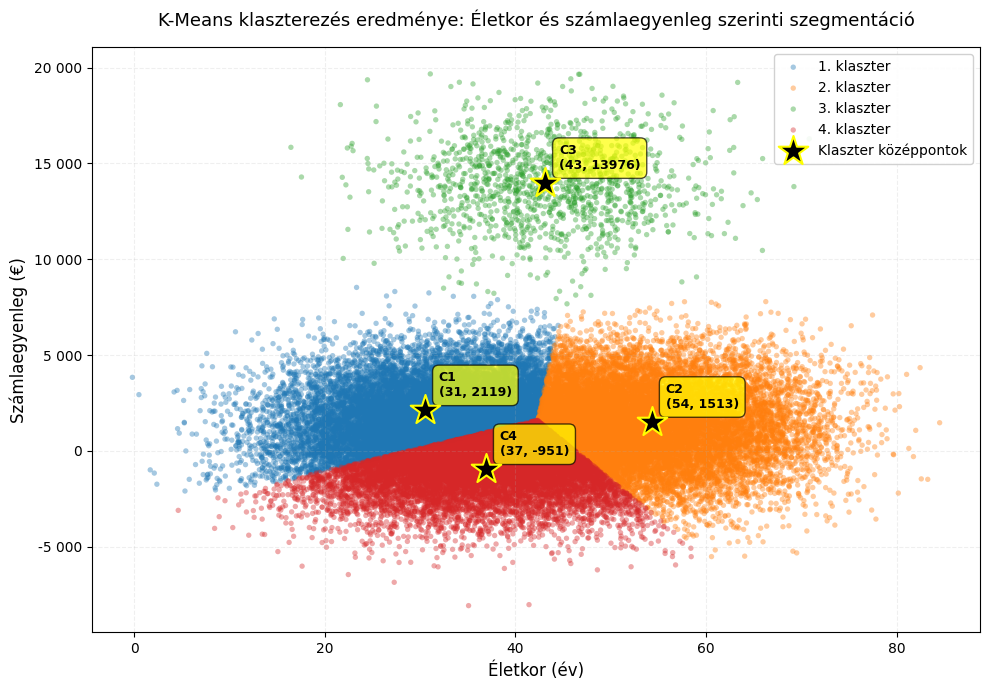

In [28]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Reprezentatív adatok generálása a notebook statisztikái alapján
np.random.seed(42)

# Szintetikus adatok generálása minden klaszterhez
data_list = []
for i, params in enumerate(cluster_params):
    ages = np.random.normal(params['mean_age'], 8, params['n_samples'])
    balances = np.random.normal(params['mean_balance'], 2000, params['n_samples'])
    cluster_labels = np.full(params['n_samples'], i)
    
    cluster_df = pd.DataFrame({
        'age': ages,
        'balance': balances,
        'cluster': cluster_labels
    })
    data_list.append(cluster_df)

ah = pd.concat(data_list, ignore_index=True)

# K-means klaszterezés végrehajtása
X = ah[['age', 'balance']].copy()
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
ah['cluster'] = kmeans.fit_predict(X_scaled)

# Középpontok visszaalakítása az eredeti skálára
scaler = StandardScaler().fit(X)
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

# Scatter plot létrehozása
fig, ax = plt.subplots(figsize=(10, 7))

# Színek definiálása - professzionális paletta
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
cluster_labels = ['1. klaszter', '2. klaszter', '3. klaszter', '4. klaszter']

# Minden klaszter ábrázolása
for i in range(4):
    cluster_data = ah[ah['cluster'] == i]
    ax.scatter(cluster_data['age'], cluster_data['balance'], 
               c=colors[i], label=cluster_labels[i], alpha=0.4, s=15, edgecolors='none')

# Középpontok ábrázolása csillag jelölővel
ax.scatter(centroids_original[:, 0], centroids_original[:, 1], 
           c='black', marker='*', s=500, edgecolors='yellow', linewidths=1.5,
           label='Klaszter középpontok', zorder=10)

# Koordináták hozzáadása annotációként
for i, (x, y) in enumerate(centroids_original):
    ax.annotate(f'C{i+1}\n({x:.0f}, {y:.0f})', 
                (x, y), 
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=9,
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
                fontweight='bold')

ax.set_xlabel('Életkor (év)', fontsize=12)
ax.set_ylabel('Számlaegyenleg (€)', fontsize=12)
ax.set_title('K-Means klaszterezés eredménye: Életkor és számlaegyenleg szerinti szegmentáció', 
             fontsize=13, pad=15)
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.2, linestyle='--')

# Y tengely formázása ezres elválasztóval
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'.replace(',', ' ')))

plt.tight_layout()
plt.savefig('ábrák\kmeans_cluster_viz.png', dpi=300, bbox_inches='tight')